**Protein Classification**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Human protein test')
#import utils
from utils import *

In [0]:
import pickle
import PIL.Image
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers import MaxPooling2D, LeakyReLU, Dropout, Input,Flatten,Dense
from keras.models import Model
from keras.models import model_from_json
%matplotlib inline

*Obtención de datos*

In [0]:
#dt = "/content/drive/My Drive/train_resize64.pkl"
dt = "/content/drive/My Drive/Human protein/train_resize64.pkl"
dbfile = open(dt, 'rb')      
data = pickle.load(dbfile) 
dbfile.close() 


*Exploración y preprocesamiento de los datos*


In [0]:
list(data.keys())

['Images', 'Target']

(64, 64)
(23,)


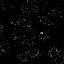

In [0]:
ig = data['Images'][10000]
igc1 = data['Target'][10000]
print(ig.shape)
print(igc1)
newim = PIL.Image.fromarray(ig)
newim

In [0]:
data = pd.DataFrame.from_dict(data)
data.head()

,Images,Target
0,"[[0, 29, 19, 1, 0, 0, 5, 0, 3, 0, 26, 20, 4, 3...","(16, 0)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 15, 6, 7...","(7, 1, 2, 0)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(5,)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(1,)"
4,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0,...","(18,)"


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31072 entries, 0 to 31071
Data columns (total 2 columns):
Images    31072 non-null object
Target    31072 non-null object
dtypes: object(2)
memory usage: 485.6+ KB


In [0]:
Labels = ['Nucleoplasm','Nuclear_membrane','Nucleoli','Nucleoli_fibrillar_center','Nuclear_speckles',
          'Nuclear_bodies','Endoplamatic_reticulum','Golgi_apparatus','Peroxisomes','Endosomes','Lysosomes',
          'Intermediate_filaments','Actin_filaments','Focal_adhesion_sites','Microtubules','Microtubule_ends',
          'Cytokinetic_bridge','Mitotic_spindle','Microtubule_organizing_center','Centrosome','Lipid_droplets',
          'Plasma_membrane','Cell_junctions','Mitochondria','Aggresome','Cytosol','Cytoplasmic_bodies',
          'Rods_&_rings']

In [0]:
one_hot = MultiLabelBinarizer()
x = one_hot.fit_transform(data['Target'])
dfOneHot = pd.DataFrame(x, columns = Labels)
data = pd.concat([data, dfOneHot], axis=1)
data.head(3)

,Images,Target,Nucleoplasm,Nuclear_membrane,Nucleoli,Nucleoli_fibrillar_center,Nuclear_speckles,Nuclear_bodies,Endoplamatic_reticulum,Golgi_apparatus,Peroxisomes,Endosomes,Lysosomes,Intermediate_filaments,Actin_filaments,Focal_adhesion_sites,Microtubules,Microtubule_ends,Cytokinetic_bridge,Mitotic_spindle,Microtubule_organizing_center,Centrosome,Lipid_droplets,Plasma_membrane,Cell_junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic_bodies,Rods_&_rings
0,"[[0, 29, 19, 1, 0, 0, 5, 0, 3, 0, 26, 20, 4, 3...","(16, 0)",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 15, 6, 7...","(7, 1, 2, 0)",1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(5,)",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X = data.iloc[:,0]
y = data.iloc[:,2:]
print('Tamaño X: ' + str(X.shape))
print('Tamaño y: ' + str(y.shape))

Tamaño X: (31072,)
Tamaño y: (31072, 28)


In [0]:
X_train, X_test, y_train, y_test = train_test_split( data['Images'], data[Labels], test_size=0.3, random_state=62)

In [0]:
print('Tamaño X: ' + str(X_train.shape))
print('Tamaño y: ' + str(y_train.shape))


Tamaño X: (21750,)
Tamaño y: (21750, 28)


In [0]:
X_train = np.array(list(x for x in X_train))
X_train=X_train.reshape(*X_train.shape,1)
X_test = np.array(list(x for x in X_test))
X_test=X_test.reshape(*X_test.shape,1)
print(X_train.shape)
print(X_test.shape)

(21750, 64, 64, 1)
(9322, 64, 64, 1)


*Creación del modelo* 



In [0]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [0]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [0]:
input_layer = Input(shape=(64,64,1))
x = Conv2D(filters=64,kernel_size=3,strides=1,padding='same', activation='relu',)(input_layer)
x = Conv2D(filters=64,kernel_size=3,strides=1,padding='same', activation='relu',)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters=128,kernel_size=3,strides=1,padding='same',activation='relu')(x)
x = Conv2D(filters=128,kernel_size=3,strides=1,padding='same',activation='relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters=256,kernel_size=3,strides=1,padding='same',activation='relu')(x)
x = Conv2D(filters=256,kernel_size=3,strides=1,padding='same',activation='relu')(x)
x = Conv2D(filters=256,kernel_size=3,strides=1,padding='same',activation='relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)
x = Dense(512)(x)
x = Dense(512)(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

output_layer = Dense(units=28,activation='sigmoid')(x)
full_net = Model(input_layer, output_layer)
full_net.compile(
    optimizer='adam',
    loss = macro_soft_f1,
    metrics=[macro_f1])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
reduction_indices is deprecated, use axis instead


In [0]:
full_net.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0   

In [0]:
history = full_net.fit(X_train,
                    y_train,
                    batch_size = 100,
                    epochs=20,
                    validation_data=(X_test, y_test)
                    )




Train on 21750 samples, validate on 9322 samples
Epoch 1/20





21750/21750 [==============================] - 59s 3ms/step - loss: 0.8895 - macro_f1: 0.1125 - val_loss: 0.9322 - val_macro_f1: 0.0620
Epoch 2/20
21750/21750 [==============================] - 48s 2ms/step - loss: 0.8830 - macro_f1: 0.1183 - val_loss: 0.8824 - val_macro_f1: 0.1173
Epoch 3/20
21750/21750 [==============================] - 48s 2ms/step - loss: 0.8764 - macro_f1: 0.1250 - val_loss: 0.8875 - val_macro_f1: 0.1135
Epoch 4/20
21750/21750 [==============================] - 48s 2ms/step - loss: 0.8714 - macro_f1: 0.1299 - val_loss: 0.8681 - val_macro_f1: 0.1336
Epoch 5/20
21750/21750 [==============================] - 48s 2ms/step - loss: 0.8664 - macro_f1: 0.1349 - val_loss: 0.8905 - val_macro_f1: 0.1110
Epoch 6/20
21750/21750 [==============================] - 48s 2ms/step - loss: 0.8646 - macro_f1: 0.1366 - val_loss: 0.8670 - val_macro_f1: 0.1334
Epoch 7/20
21750/21750 [==============================] - 48s

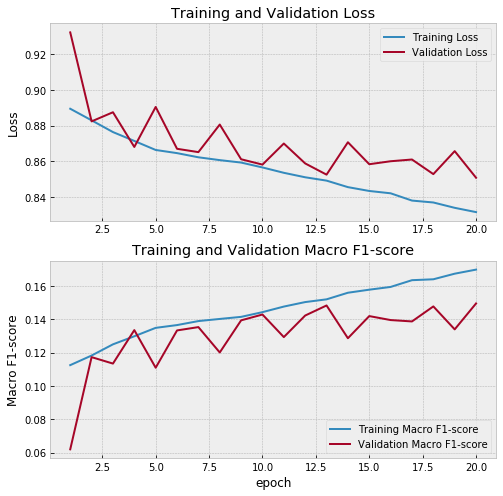

In [0]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

In [0]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.85
Macro F1-score: 0.15


In [0]:
y_pred = full_net.predict(X_test,verbose=True)

9322/9322 [==============================] - 7s 745us/step


In [0]:
model_json = full_net.to_json()
with open("/content/drive/My Drive/Human protein test/full_net.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
full_net.save_weights("full_net.h5")
print("Modelo guardado en disco")

Modelo guardado en disco


*Prueba del modelo con datos nunca antes vistos*

In [0]:
dt = "/content/drive/My Drive/Human protein/test_resize64.pkl"
dbfile = open(dt, 'rb')      
data = pickle.load(dbfile) 
dbfile.close() 

In [0]:
json_file = open('/content/drive/My Drive/Human protein/full_net.json', 'r')
loaded_model_json = json_file.read()
print(loaded_model_json)
json_file.close()
loaded_model = model_from_json(loaded_model_json)

FileNotFoundError: ignored

In [0]:
loaded_model.load_weights("full_net.h5")
print("Modelo cargado desde disco ")

Modelo cargado desde disco 


In [0]:
datatest = pd.DataFrame.from_dict(data)
datatest.head()

,Id,Images
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,"[[4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,"[[67, 48, 59, 21, 47, 53, 72, 45, 24, 59, 68, ..."
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 42, 17, 10, 2..."
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,"[[0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0,..."


In [0]:
test = np.array(list(x for x in datatest['Images']))
test = test.reshape(*test.shape,1)
print(test.shape)

(11702, 64, 64, 1)


In [0]:
loaded_model.compile(
    loss=macro_soft_f1, 
    optimizer='adam', 
    metrics=[macro_f1])

salida = loaded_model.predict(test, verbose=0)
print(salida)

[[9.9999940e-01 1.4901161e-07 9.9997079e-01 ... 0.0000000e+00
  4.7683716e-07 7.4505806e-07]
 [9.6519792e-01 1.4796853e-04 6.1989725e-03 ... 4.8830751e-01
  7.9634786e-04 1.9568205e-04]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [9.5719898e-01 0.0000000e+00 4.3400556e-02 ... 5.0839782e-04
  1.2463331e-04 2.1889806e-04]
 [9.9996090e-01 2.0861626e-07 4.7731996e-03 ... 2.6449919e-02
  3.7521124e-05 3.1292439e-06]
 [9.9999088e-01 8.2068205e-02 5.1073754e-01 ... 7.7205896e-04
  2.4467707e-05 6.8724155e-05]]


In [0]:
def classifyData(salida):
    for i in range (0,len(salida)):
        l = np.round(salida[i],0)
        if 1.in l:
            salida[i] = l
        else:
            salida[i][np.argmax(salida[i])] = 1
            salida[i] = np.round(salida[i],0)
    return salida

In [0]:
salida = classifyData(salida)

In [0]:
outputs = []
for row in salida:
    t = ""
    for c, val in enumerate(row):
        if val == 1:
            t = t + " "+str(c)
    outputs.append(t)

In [0]:
df = pd.DataFrame({"Id" : datatest['Id'], "Predicted" : outputs})
df.to_csv("/content/drive/My Drive/Human protein/submission3.csv", index=False)